In [12]:
import pandas as pd
import numpy as np
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

from scipy.sparse import hstack, vstack, csr_matrix
from scipy import sparse

from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Dense, Dropout, merge, concatenate
from keras.layers import LSTM, Embedding, GRU
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras import optimizers

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers.normalization import BatchNormalization
from keras_tqdm import TQDMNotebookCallback, TQDMCallback


from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.svm import SVC, LinearSVC, NuSVC

from sklearn.metrics import mean_squared_error, accuracy_score, log_loss
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif, chi2, SelectFromModel
from sklearn.feature_selection import VarianceThreshold

from sklearn import preprocessing
from sklearn.decomposition import PCA

import gensim
from gensim.models import Word2Vec

import re
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy

from multiprocessing import Pool

In [2]:
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt

#font = {'family': 'Verdana', 'weight': 'normal'}
#rc('font', **font)
matplotlib.style.use('ggplot')

%matplotlib inline

pd.set_option('display.max_rows', 15)

In [3]:
spacy.util.set_data_path('/home/data/spacy/')
nlp = spacy.load('en')

# Загрузка данных

In [4]:
train_set = pd.read_csv('/home/data/share/quora/train.csv', index_col=0)
test_set = pd.read_csv('/home/data/share/quora/test.csv', index_col=0)

In [5]:
train_set.head(10)

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0


## Ответы

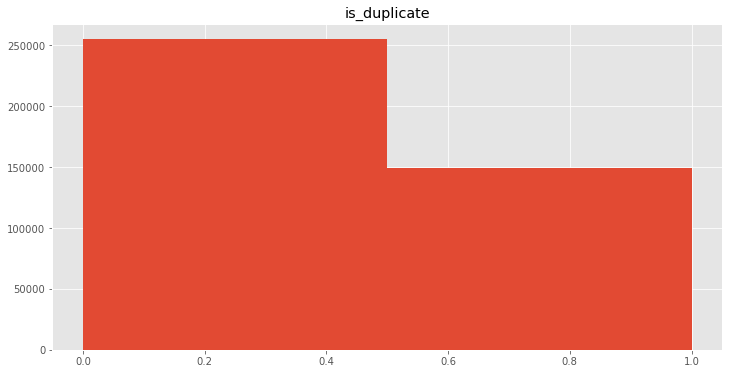

In [6]:
train_set.hist(column='is_duplicate', bins=2, figsize=(12, 6))
plt.show()

In [7]:
Y_train = train_set['is_duplicate']

## Пробелы в данных

In [8]:
train_set[train_set.isnull().any(axis=1)]

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
105780,174363,174364,How can I develop android app?,NaN,0
201841,303951,174364,How can I create an Android app?,NaN,0


In [9]:
test_set[test_set.isnull().any(axis=1)]

,question1,question2
test_id,,
379205,How I can learn android app development?,NaN
817520,How real can learn android app development?,NaN
943911,How app development?,NaN
1046690,NaN,How I what can learn android app development?
1270024,How I can learn app development?,NaN
1461432,NaN,How distinct can learn android app development?


In [10]:
train_set.fillna('empty_string', inplace=True)
test_set.fillna('empty_string', inplace=True)

In [11]:
train_set

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
...,...,...,...,...,...
404283,537924,537925,What do you think of the removal of the MagSaf...,What will the CPU upgrade to the 2016 Apple Ma...,0


# Tokenization

# Множества(train, test, validation)

In [18]:
# load tokenized questions
train_q1_tokenized_objects = load_tokenized_series('train_q1_tokenized.csv')
train_q2_tokenized_objects = load_tokenized_series('train_q2_tokenized.csv')
test_q1_tokenized_objects = load_tokenized_series('test_q1_tokenized.csv')
test_q2_tokenized_objects = load_tokenized_series('test_q2_tokenized.csv')

In [19]:
train_index = train_q1_tokenized_objects.index
train_pairs = pd.DataFrame(index=train_index)
train_pairs['question1'] = train_q1_tokenized_objects
train_pairs['question2'] = train_q2_tokenized_objects
train_pairs = train_pairs.values

test_index = test_q1_tokenized_objects.index
test_pairs = pd.DataFrame(index=test_index)
test_pairs['question1'] = test_q1_tokenized_objects
test_pairs['question2'] = test_q2_tokenized_objects
test_pairs = test_pairs.values

In [20]:
train_tokens, validation_tokens, y_train, y_validation = train_test_split(train_pairs, Y_train.values,
                                                                          test_size=0.1, random_state=42)
test_tokens = test_pairs

# Features

In [20]:
tokenizer = Tokenizer(num_words=200000)
all_questions = np.concatenate([train_set['question1'].values,
                                train_set['question2'].values,
                                test_set['question1'].values,
                                test_set['question2'].values])

tokenizer.fit_on_texts(all_questions)

train_question1_sequences = tokenizer.texts_to_sequences(train_set['question1'].values)
train_question2_sequences = tokenizer.texts_to_sequences(train_set['question2'].values)
test_question1_sequences = tokenizer.texts_to_sequences(test_set['question1'].values)
test_question2_sequences = tokenizer.texts_to_sequences(test_set['question2'].values)

word_index = tokenizer.word_index

## word2vec squence

In [21]:
def space_tokenizer(s):
    return s.split(' ')

def text_from_tokens_spacy(tokens):
    tokens = [token.lower_ for token in tokens]
    return ' '.join(tokens)

In [22]:
w2v_parh = os.path.join(os.sep, os.path.abspath('/home/data/word2vec/english/GoogleNews-vectors-negative300.bin'))
w2v = gensim.models.KeyedVectors.load_word2vec_format(w2v_parh, binary=True)
w2v.init_sims(replace=True)

In [23]:
def tokens_to_embeddings(text):
    sequence = [w2v.syn0norm[w2v.vocab[token].index] for token in space_tokenizer(text) if word in w2v.vocab]

    if not sequence:
        return np.zeros(300)

    return np.concatenate(sequence)

In [44]:
def tokens_to_integers(tokens, vocabulary):
    return [vocabulary[token]+1 if token in vocabulary else 0 for token in tokens if token in vocabulary]

def get_vocabulary(texts, min_df=1):
    count_vectorizer = CountVectorizer(analyzer="word", lowercase=False, tokenizer=space_tokenizer, min_df=min_df, binary=True)
    count_vectorizer = count_vectorizer.fit(texts)
    vocabulary = count_vectorizer.vocabulary_
    
    return vocabulary
    
def texts_to_integers(texts, vocabulary):
    sequences = [tokens_to_integers(text.split(' '), vocabulary) for text in texts]
    
    return sequences

In [45]:
all_texts = np.concatenate([train_pairs[:, 0], train_pairs[:, 1]])

vocab = get_vocabulary(all_texts)
vocab_len = len(vocab)

In [46]:
train_sequences = train_tokens.copy()
train_sequences[:, 0] = texts_to_integers(train_sequences[:, 0], vocab)
train_sequences[:, 1] = texts_to_integers(train_sequences[:, 1], vocab)

validation_sequences = validation_tokens.copy()
validation_sequences[:, 0] = texts_to_integers(validation_sequences[:, 0], vocab)
validation_sequences[:, 1] = texts_to_integers(validation_sequences[:, 1], vocab)

test_sequences = test_tokens.copy()
test_sequences[:, 0] = texts_to_integers(test_sequences[:, 0], vocab)
test_sequences[:, 1] = texts_to_integers(test_sequences[:, 1], vocab)

In [101]:
embedding_dim = 300
embedding_weights = np.zeros((vocab_len+1, embedding_dim))
for word, index in vocab.items():
    if word in w2v.vocab:
        embedding_weights[index, :] = w2v.syn0norm[w2v.vocab[word].index] 
        
print('Null word embeddings: %d' % np.sum(np.sum(embedding_weights, axis=1) == 0))

NameError: name 'word_embedding_matrix' is not defined

In [48]:
lens = [len(l) for l in train_sequences[:, 0]]
print('Train, question 1:')
print('\tMax: {}, Min: {}, Mean: {}, percentile 0.95: {}'.format(max(lens), min(lens), np.mean(lens), np.percentile(lens, 95)))

lens = [len(l) for l in train_sequences[:, 1]]
print('Train, question 2:')
print('\tMax: {}, Min: {}, Mean: {}, percentile 0.95: {}'.format(max(lens), min(lens), np.mean(lens), np.percentile(lens, 95)))
print('\n')

lens = [len(l) for l in validation_sequences[:, 0]]
print('Validation, question 1:')
print('\tMax: {}, Min: {}, Mean: {}, percentile 0.95: {}'.format(max(lens), min(lens), np.mean(lens), np.percentile(lens, 95)))

lens = [len(l) for l in validation_sequences[:, 1]]
print('Validation, question 2:')
print('\tMax: {}, Min: {}, Mean: {}, percentile 0.95: {}'.format(max(lens), min(lens), np.mean(lens), np.percentile(lens, 95)))
print('\n')

lens = [len(l) for l in test_sequences[:, 0]]
print('Test, question 1:')
print('\tMax: {}, Min: {}, Mean: {}, percentile 0.95: {}'.format(max(lens), min(lens), np.mean(lens), np.percentile(lens, 95)))

lens = [len(l) for l in test_sequences[:, 1]]
print('Test, question 2:')
print('\tMax: {}, Min: {}, Mean: {}, percentile 0.95: {}'.format(max(lens), min(lens), np.mean(lens), np.percentile(lens, 95)))
print('\n')

Train, question 1:
	Max: 152, Min: 1, Mean: 12.613437548954133, percentile 0.95: 25.0
Train, question 2:
	Max: 271, Min: 1, Mean: 12.886632532752891, percentile 0.95: 27.0


Validation, question 1:
	Max: 77, Min: 1, Mean: 12.644141581538005, percentile 0.95: 25.0
Validation, question 2:
	Max: 269, Min: 1, Mean: 12.843206609117217, percentile 0.95: 27.0


Test, question 1:
	Max: 272, Min: 0, Mean: 12.665855001884221, percentile 0.95: 26.0
Test, question 2:
	Max: 274, Min: 0, Mean: 12.702333450990624, percentile 0.95: 27.0




In [93]:
maxlen = 45

train_sequences_q1 = sequence.pad_sequences(train_sequences[:, 0], maxlen=maxlen)
train_sequences_q2 = sequence.pad_sequences(train_sequences[:, 1], maxlen=maxlen)
train_sequences = np.array([pair for pair in list(zip(train_sequences_q1, train_sequences_q2))])
del train_sequences_q1, train_sequences_q2

validation_sequences_q1 = sequence.pad_sequences(validation_sequences[:, 0], maxlen=maxlen)
validation_sequences_q2 = sequence.pad_sequences(validation_sequences[:, 1], maxlen=maxlen)
validation_sequences = np.array([pair for pair in list(zip(validation_sequences_q1, validation_sequences_q2))])
del validation_sequences_q1, validation_sequences_q2

test_sequences_q1 = sequence.pad_sequences(test_sequences[:, 0], maxlen=maxlen)
test_sequences_q2 = sequence.pad_sequences(test_sequences[:, 1], maxlen=maxlen)
test_sequences = np.array([pair for pair in list(zip(test_sequences_q1, test_sequences_q2))])
del test_sequences_q1, test_sequences_q2

In [94]:
train_sequences.shape, validation_sequences.shape, test_sequences.shape

((363861, 2, 45), (40429, 2, 45), (2345796, 2, 45))

In [95]:
x_train = train_sequences
x_validation = validation_sequences
x_test = test_sequences

# Models

# NN

In [97]:
max_features, embedding_dim, maxlen = vocab_len+1, 300, maxlen

## With Embedding

### batch_generator

In [98]:
def batch_generator(Q1, Q2, Y, batch_size, shuffle=False):
    n = Y.shape[0]
    number_of_batches, counter, shuffle_index = n//batch_size, 0, np.arange(n)
    
    if shuffle:
        np.random.shuffle(shuffle_index)

    Q1, Q2, Y =  Q1[shuffle_index], Q2[shuffle_index], Y[shuffle_index]
    
    while True:
        for counter in range(number_of_batches+1):
            index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
            X, Y_batch = [Q1[index_batch], Q2[index_batch]], Y[index_batch]
            yield X, Y_batch
            
        if shuffle:
            np.random.shuffle(shuffle_index)

### model architecture

In [99]:
def get_representation(input_shape):
    representation = Sequential()
    representation.add(Embedding(max_features, embedding_dim, input_length=input_shape, weights=[embedding_weights]))
    representation.add(LSTM(embedding_dim))
    
    return representation

def build_model(question_shape):
    first_question = Input(shape=(question_shape, ))
    second_question = Input(shape=(question_shape, ))
    
    representation = get_representation(question_shape)
    
    first_representation = representation(first_question)
    second_representation = representation(second_question)
    
    merged_vectors = concatenate([first_representation, second_representation])
    output_proba = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(merged_vectors)
    
    model = Model(
        inputs=[first_question, second_question],
        outputs=output_proba
    )
    
    return model
    
def get_nn_model(*, path_to_hdf5=False, input_shape=None):
    model = build_model(input_shape) 
    #optimizer = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # load pretrained weights
    if path_to_hdf5:
        model.load_weights(path_to_hdf5)

    print(model.summary())
    return model

filepath="weights_{epoch:02d}_{val_loss:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=1, mode='min')
callbacks_list = [checkpoint, early_stopping, TQDMNotebookCallback()]

### training

In [100]:
batch_size = 1024
steps_per_epoch = y_train.shape[0]//batch_size
validation_steps = y_validation.shape[0]//batch_size
input_shape = maxlen

train_generator = batch_generator(x_train[:, 0], x_train[:, 1], y_train, batch_size, shuffle=False)
validation_generator = batch_generator(x_validation[:, 0], x_validation[:, 1], y_validation, batch_size, shuffle=False)

model = get_nn_model(input_shape=input_shape)
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              epochs=5, verbose=2, callbacks=callbacks_list,
                              max_q_size=2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 45)            0                                            
____________________________________________________________________________________________________
input_12 (InputLayer)            (None, 45)            0                                            
____________________________________________________________________________________________________
sequential_6 (Sequential)        (None, 300)           26892000                                     
____________________________________________________________________________________________________
concatenate_6 (Concatenate)      (None, 600)           0                                            
___________________________________________________________________________________________

The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


None
Epoch 1/5
Epoch 00000: val_loss improved from inf to 0.48899, saving model to weights_00_0.489.hdf5
119s - loss: 0.5172 - acc: 0.7453 - val_loss: 0.4890 - val_acc: 0.7669
Epoch 2/5


The installed widget Javascript is the wrong version.


Epoch 00001: val_loss did not improve
121s - loss: 0.4393 - acc: 0.7930 - val_loss: 0.4961 - val_acc: 0.7657
Epoch 3/5


The installed widget Javascript is the wrong version.


Epoch 00002: val_loss did not improve
181s - loss: 0.3663 - acc: 0.8299 - val_loss: 0.5715 - val_acc: 0.7594
Epoch 4/5


The installed widget Javascript is the wrong version.


Epoch 00003: val_loss did not improve
249s - loss: 0.2966 - acc: 0.8628 - val_loss: 0.6633 - val_acc: 0.7510
Epoch 5/5


The installed widget Javascript is the wrong version.


Epoch 00004: val_loss did not improve
248s - loss: 0.2578 - acc: 0.8812 - val_loss: 0.8098 - val_acc: 0.7628

